In [34]:
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import torch.nn.functional as F
from tqdm.notebook import tqdm
import math
from IPython.display import clear_output

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
class ReplayBuffer():
    def __init__(self,max_capacity = 2000,batch_size = 4):
        self.max_capacity = max_capacity
        self.buffer = deque(maxlen=max_capacity)
        self.batch_size = batch_size
        
    def add(self,state,action,reward,next_state,done):
        state = np.expand_dims(state,axis=0)
        next_state = np.expand_dims(next_state,axis=0)
        self.buffer.append([state,action,reward,next_state,done])
    def clear_histoy(self):
        self.buffer.clear()
        
    def get_batch(self):
        state,action,reward,next_state,done = zip(*random.sample(self.buffer,self.batch_size))
        return np.concatenate(state),action,reward,np.concatenate(next_state),done
    
    def __len__(self):
        return len(self.buffer)
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    

# CartPole

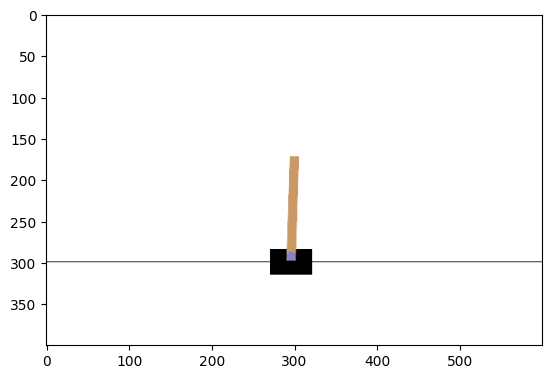

In [7]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())
plt.show()

In [121]:
class DQN(nn.Module):
    def __init__(self,n_states,n_actions):
        super(DQN,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(n_states,64),
            nn.ReLU(),
        )
        self.value = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.action_value = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,n_actions)
        )

    def forward(self,state):
        x = self.f(state)
        v = self.value(x)
        a = self.action_value(x) - self.action_value(x).mean()
        x = v+a
        return x
    


In [122]:
Q = DQN(4,2).to(device)
static_Q = DQN(4,2).to(device)
static_Q.load_state_dict(Q.state_dict())

<All keys matched successfully>

In [123]:
def select_action(state,epsilon = 1e-6):
    state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [124]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

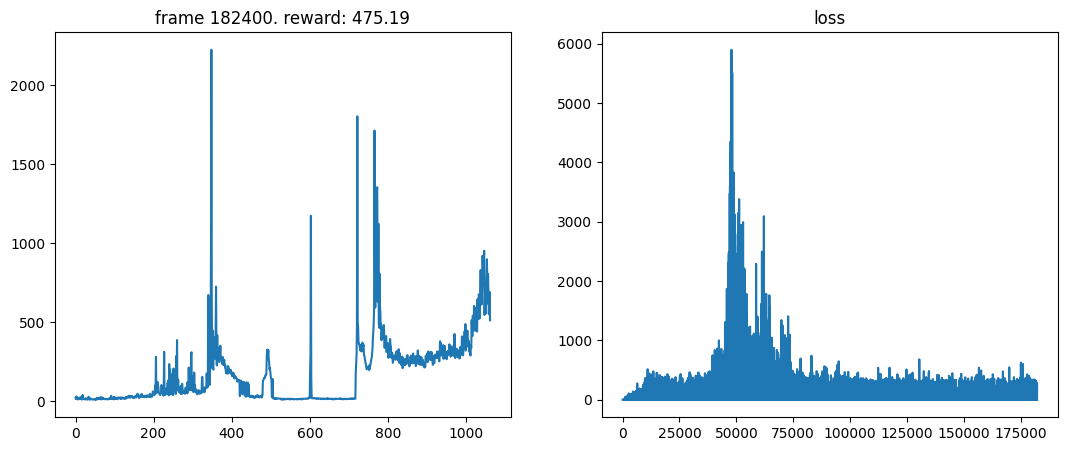

DONE


In [125]:
replaybuffer = ReplayBuffer(max_capacity=10000,batch_size=16)
num_steps = 1000000
gamma = 0.99
optimizer = torch.optim.Adam(Q.parameters(),lr=1e-4)
average_game_reward = []
losses = []
game_reward = 0
state,info = env.reset()
for t in tqdm(range(num_steps)):
    epsilon = epsilon_by_frame(t)
    action = select_action(state,epsilon=epsilon)
    next_state,reward,done,_,info = env.step(action)
    replaybuffer.add(state,action,reward,next_state,done)
    game_reward += reward
    if done:
        state,info = env.reset()
        average_game_reward.append(game_reward)
        game_reward = 0
    state = next_state
    
        
    
    if  len(replaybuffer)> 200:
        s,action,reward,next_state,done = replaybuffer.get_batch()
        s = torch.from_numpy(s).to(device)
        action = torch.tensor(action).to(device)
        reward = torch.tensor(reward).to(device)
        next_state = torch.from_numpy(next_state).to(device)
        not_done =torch.tensor(1-np.array(done)).to(device)
        
        target = reward + not_done * (gamma * torch.max(static_Q(next_state).detach(),dim=1)[0])
        prediction = Q(s)
        prediction = prediction[range(len(action)),action]
        loss = F.mse_loss(prediction,target)
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(Q.parameters(),5000)
        optimizer.step()
        losses.append(loss.item())
        static_Q.load_state_dict(Q.state_dict())
        if t % 200 == 0:
            plot(t,average_game_reward,losses)

            if np.mean(average_game_reward[-100:]) > env.spec.reward_threshold:
                print('DONE')
                break

In [128]:
# env_2 = gym.make('CartPole-v1',render_mode = 'human')
# #env_2 = gym.wrappers.RecordVideo(env_2,'.',episode_trigger=lambda x:True)
# for episode in range(5):
#     state,info = env_2.reset()
#     rewards = 0
#     while True:
#         action = select_action(state,epsilon=0)
#         next_state,reward,done,_,info = env_2.step(action)
#         if done:
#             break
#         state = next_state
#         rewards+= reward
#     print('rewad',rewards)
# env_2.close()